In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. Splilt step for generate training and validation data

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
#from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence, check_and_create

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

scale = 25

############ Path Setting ##############
outPath = r"Prediction/"
outPath = outPath + timestr + '_' + str(scale)+ "/"
check_and_create(outPath)

Using TensorFlow backend.


## Models

## Prepare Training Data

In [2]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

p_size_1 = 128 # Compared with 256, which larger may generate round corners
trainPath = r"../tmp_data/data_feng/geb" + str(scale) +  "/"

# save image patch arrays
x_train_sim = np.load(trainPath + "x_train_sim.npy")
y_train_sim = np.load(trainPath + "y_train_sim.npy")
x_test_sim = np.load(trainPath + "x_test_sim.npy")
y_test_sim = np.load(trainPath + "y_test_sim.npy")

Input Shape of the models (31760, 128, 128, 1)
Test Shape of the models (3528, 128, 128, 1)


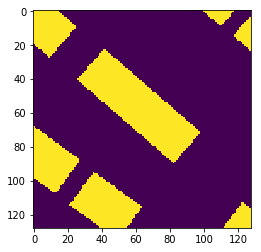

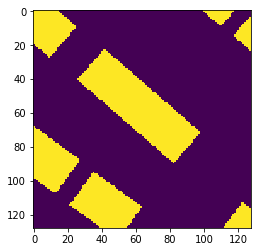

In [3]:
plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)
print('Test Shape of the models', x_test_sim.shape)

In [4]:
from kmodels import create_model_add_skips_2

opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#opt1 = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model_ex1 = create_model(opt1, input_shape1)
#model_ex1 = create_model_batch(opt1, input_shape1) # Not good as the skip connection
#model_ex1 = create_model_add_skips(opt1, input_shape1)
#model_ex1 = create_model_add_skips_3(opt1, input_shape1) # Add max pool but not better


model_ex1 = create_model_add_skips_2(opt1, input_shape1)

model_ex1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
flat_conv_a (Conv2D)            (None, None, None, 2 240         input_1[0][0]                    
__________________________________________________________________________________________________
flat_conv_b (Conv2D)            (None, None, None, 2 5208        flat_conv_a[0][0]                
__________________________________________________________________________________________________
down_conv_1 (Conv2D)            (None, None, None, 2 5208        flat_conv_b[0][0]                
__________________________________________________________________________________________________
flat_conv_

In [5]:
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [6]:
data_gen_args = dict(rotation_range=180.)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
BATCH_SIZE = 16
result_generator = zip(image_datagen.flow(x_train_sim, batch_size=BATCH_SIZE, seed=seed), 
                       mask_datagen.flow(y_train_sim, batch_size=BATCH_SIZE, seed=seed))

History1 = History()
hist1 = model_ex1.fit_generator(  result_generator,
                                  epochs = 100,
                                  steps_per_epoch=2000,
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[History1, 
                                             EarlyStopping(patience=10), 
                                             ReduceLROnPlateau(patience = 3, verbose = 0),
                                             ModelCheckpoint(outPath + "weights.hdf5", 
                                                             save_best_only = True, 
                                                             save_weights_only = False)],
                                  validation_data=(x_test_sim, y_test_sim))

Epoch 1/100
2000/2000 [==============================] - 166s 83ms/step - loss: 0.0842 - acc: 0.9558 - val_loss: 0.0702 - val_acc: 0.9788
Epoch 2/100
2000/2000 [==============================] - 167s 84ms/step - loss: 0.0693 - acc: 0.9599 - val_loss: 0.0634 - val_acc: 0.9803
Epoch 3/100
2000/2000 [==============================] - 170s 85ms/step - loss: 0.0654 - acc: 0.9606 - val_loss: 0.0592 - val_acc: 0.9813
Epoch 4/100
2000/2000 [==============================] - 171s 85ms/step - loss: 0.0625 - acc: 0.9614 - val_loss: 0.0560 - val_acc: 0.9821
Epoch 5/100
2000/2000 [==============================] - 171s 85ms/step - loss: 0.0601 - acc: 0.9620 - val_loss: 0.0543 - val_acc: 0.9828
Epoch 6/100
2000/2000 [==============================] - 171s 85ms/step - loss: 0.0592 - acc: 0.9623 - val_loss: 0.0526 - val_acc: 0.9833
Epoch 7/100
2000/2000 [==============================] - 171s 85ms/step - loss: 0.0581 - acc: 0.9626 - val_loss: 0.0518 - val_acc: 0.9834
Epoch 8/100
2000/2000 [===========

## Training

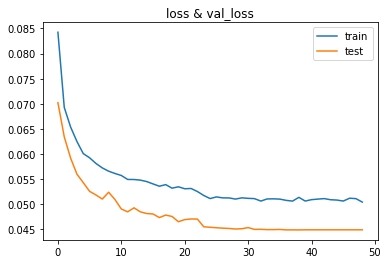

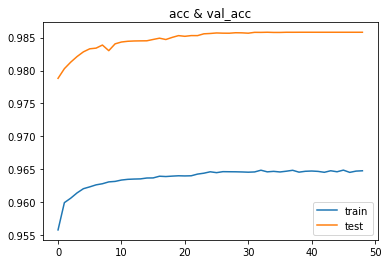

In [7]:
import os
import numpy as np
import pandas as pd
from data_helper import predict_15k, save_hist, save_model

### Save history
save_hist(History1, outPath)
### Save model
#save_model(model_ex1, outPath)
# Retain best model
#from keras import models
#model_ex1 = models.load_model(outPath + "weights.hdf5")

## Independent Test

15k Example: 
accuracy: 0.976413099134
IoU: 0.885579034522
accuracy: 0.977196557971
IoU: 0.891215498461
15k Example: 
accuracy: 0.982896331738
IoU: 0.926101517386
accuracy: 0.987502584781
IoU: 0.945999525332


,Input vs Target (Test1),Prediction vs Target (Test1),Input vs Target (Test2),Prediction vs Target (Test2)
Metrics,,,,
Accuracy,0.976413,0.977197,0.982896,0.987503
IoU,0.885579,0.891215,0.926102,0.946000


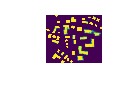

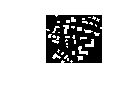

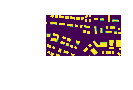

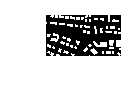

In [8]:
testPath = r"Data/Testing/"

all_records = []

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest1_input_inv.png", r"FTest1_output_inv.png")
all_records.extend(records)

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest2_input_inv.png", r"FTest2_output_inv.png")
all_records.extend(records)

df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'
df